# INTRODUCTION
This notebook contains workflow to annotating cell types in Xenium liver cancer dataset with label Transfer. The notebook is hugely based on analysis guides provided by 10X Genomics on the following website:
https://www.10xgenomics.com/analysis-guides/xenium-cell-type-annotation. While the 10X Genomics' analysis guides is completely Seurat and R-based, I have implemented the analogous steps in python using scanpy and anndata. To implement such steps, first we need to create an anndata object to feed the dataset into scanpy tools since the liver cancer dataset comes in zarr format and scanpy does not have zarr reader utility for reading and writing. To learn how to read zarr files, please visit zarr https://www.10xgenomics.com/support/software/xenium-onboard-analysis/latest/advanced/example-code or simply python documentation of zarr at https://zarr.readthedocs.io/en/stable/user-guide/arrays.html. I have written some classes and helper functions to facilitate this workflow which may be integrated in scanpy in the future for ease. In a nutshell, I have written a feature_matrix_loader.py script which has methods to load either cell by feature (NOTE: not cell by gene; a feature may not just be a gene expression) or feature by cell which can be used to construct anndata object to further pass as an argument to scanpy. To learn about anndata object please visit: https://anndata.readthedocs.io/en/stable/. Anoother useful script is cell_stat_loader.py, which has methods to obtain several spatial information about cells on individual level like the centroid position of the cell, nucleus centroid position, cell segmentation/boundaries/polygons etc. The documentation about both these scripts can be found in documents/ directory.

In [1]:
%load_ext autoreload
%autoreload 2

# set up project path
import os, sys, warnings, json
project_path = os.path.join(os.path.expanduser("~"), 'xenium_liver_cancer')
sys.path.append(project_path)
warnings.simplefilter(action="ignore", category=Warning)

# Generic libraries
import numpy as np
import anndata as ad
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Xenium libraries
from cell_stat_loader import SpatialInfo
from feature_matrix_loader import FeatureMatrixLoader

## 1. Dataset and input files
We are cell typing Xenium liver cancer dataset from 10x Genomics. The dataset is available on the 10x Genomics website under the Xenium datasets section.

Here is the link: https://www.10xgenomics.com/datasets/human-liver-data-xenium-human-multi-tissue-and-cancer-panel-1-standard

Download the dataset (you do not need to unzip it since the libraries written can handle unzipped dataset). Structure your working directory to have a sub-directory xenium_data such that the xenium_data directory tree would look like the following:

- /home/gddaslab/mxp140/xenium_liver_cancer/xenium_data/
    - diseased/
        - analysis_summary.html  
        - analysis.zarr.zip  
        - cell_feature_matrix.zarr.zip  
        - cells.zarr.zip  
        - experiment.xenium  
        - gene_panel.json  
        - morphology_mip.ome.tif  
        - transcripts.zarr.zip  
    - non_diseased/
        - analysis_summary.html  
        - analysis.zarr.zip  
        - cell_feature_matrix.zarr.zip  
        - cells.zarr.zip  
        - experiment.xenium  
        - gene_panel.json  
        - morphology_mip.ome.tif  
        - transcripts.zarr.zip  

2 directories, 16 files

A summary of the cells and gene statistics can already be found in the following html link:

Diseased-> https://cf.10xgenomics.com/samples/xenium/1.9.0/Xenium_V1_hLiver_cancer_section_FFPE/Xenium_V1_hLiver_cancer_section_FFPE_analysis_summary.html

Non-diseased-> https://cf.10xgenomics.com/samples/xenium/1.9.0/Xenium_V1_hLiver_nondiseased_section_FFPE/Xenium_V1_hLiver_nondiseased_section_FFPE_analysis_summary.html

To create visualizations like the one in the links, please see my other notebook page on data exploration: which can be found as `diseased_data_exploration.ipynb` and `non_diseased_data_exploration.ipynb` inside notebooks directory. Here we will directly start with following the 10X Xenomics analysis guides.

## 1.1 Choose a scRNA-seq reference dataset (COPIED FROM 10X GENOMICS)
Choosing an appropriate single cell reference dataset is a critical first step that will influence the quality of the transferred labels. This reference can be a single sample that you annotated manually before, or it can be a published and ideally a curated existing reference.

**What to consider when choosing your reference:**

- Is it a matched sample type? Consider matching both biological factors (tissue type, age/sex/ancestry, disease state, treatments, etc.) and technical factors (sequencing technology, FF or FFPE, whole-cell versus single nuclei).
- The reference should ideally be balanced for different cell types based on your tissue type and region. For example, a single cell reference generated from the hippocampus may not translate well to cortex data. When using public data, integrated references generated from more than one sample tend to improve reference mapping (Mölbert et al.).
- Is the reference dataset curated with confident annotations? Consider which methods were used to annotate the cell types in the reference, the sample size and number of cells in the dataset, the sequencing depth of the experiment, and whether any validation was performed.

**Recommended single cell reference sources**

There are numerous publicly available and well-documented single cell reference datasets and atlases, such as:

- Tabula Muris
- Tabula Sapiens
- CELLxGENE
- EMBL-EBI Single Cell Expression Atlas

#### 1.1.1 referece dataset selection:
Regadring first question, We select the liver dataset from Tabula Sapeins as reference dataset. To download it please follow following browsing sequence:
https://tabula-sapiens.sf.czbiohub.org/-> (Data Access) -> (Processed data available from figshare/Tabula Sapiens on figshare/Access the data) -> (select the liver data) -> Liver_TSP1_30_version2d_10X_smartseq_scvi_Nov122024.h5ad

or simply do `wget --content-disposition https://figshare.com/ndownloader/files/50851056 in the working directory. 

Then we load the reference dataset as ref_obj using scanpy since it is already a readable via scanpy.


In [2]:
ref_obj = sc.read_h5ad('../Liver_TSP1_30_version2d_10X_smartseq_scvi_Nov122024.h5ad')
ref_obj.var['ensembl_id'] = ref_obj.var['ensembl_id'].str.replace(r'\.\d+', '', regex=True)
ref_obj

AnnData object with n_obs × n_vars = 22214 × 61806
    obs: 'donor', 'tissue', 'anatomical_position', 'method', 'cdna_plate', 'library_plate', 'notes', 'cdna_well', 'old_index', 'assay', 'sample_id', 'replicate', '10X_run', '10X_barcode', 'ambient_removal', 'donor_method', 'donor_assay', 'donor_tissue', 'donor_tissue_assay', 'cell_ontology_class', 'cell_ontology_id', 'compartment', 'broad_cell_class', 'free_annotation', 'manually_annotated', 'published_2022', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ercc', 'pct_counts_ercc', '_scvi_batch', '_scvi_labels', 'scvi_leiden_donorassay_full', 'age', 'sex', 'ethnicity', 'scvi_leiden_res05_tissue', 'sample_number'
    var: 'ensembl_id', 'gene_symbol', 'genome', 'mt', 'ercc', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: '_scvi_manager_uuid', '_scvi_uuid', '_training_mode', 'age_colors', 'assay_colors', 'compartment_colors', 'donor_colors', 'leide

In [3]:
# We will only select the dataset that came from 10X platform
ref_obj = ref_obj[ref_obj.obs['method'] == '10X']
# We will only select the cells that has been manually verified by tissue expert to be the corresponding cell type.
ref_obj = ref_obj[ref_obj.obs['manually_annotated'] == 'True']
ref_obj

View of AnnData object with n_obs × n_vars = 9855 × 61806
    obs: 'donor', 'tissue', 'anatomical_position', 'method', 'cdna_plate', 'library_plate', 'notes', 'cdna_well', 'old_index', 'assay', 'sample_id', 'replicate', '10X_run', '10X_barcode', 'ambient_removal', 'donor_method', 'donor_assay', 'donor_tissue', 'donor_tissue_assay', 'cell_ontology_class', 'cell_ontology_id', 'compartment', 'broad_cell_class', 'free_annotation', 'manually_annotated', 'published_2022', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ercc', 'pct_counts_ercc', '_scvi_batch', '_scvi_labels', 'scvi_leiden_donorassay_full', 'age', 'sex', 'ethnicity', 'scvi_leiden_res05_tissue', 'sample_number'
    var: 'ensembl_id', 'gene_symbol', 'genome', 'mt', 'ercc', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: '_scvi_manager_uuid', '_scvi_uuid', '_training_mode', 'age_colors', 'assay_colors', 'compartment_colors', 'donor_colors',

#### 1.1.2 Cell types in the reference object
Regarding different cell types in reference dataset, we see that there are 20 different cell types with macrophages and hepatocytes almost equal in counts, together occupying 37%, monocyte 16% and 10% by endothelial cells. While the reference dataset does not seem balanced in all the cell types, we will come to how to create a balanced dataset later on. But for now we will simply proceed with what we have. Note: Had we not filtered out the unverified cell types, we would have ended up with 70% hepatocytes. The dataset we have now seems more appropriate dataset for referencing our cancer dataset as the reference dataset itself seems to represent diseased dataset now.

cell_types                  
macrophage                      1877
hepatocyte                      1809
monocyte                        1584
endothelial cell                1045
t cell                           945
erythrocyte                      705
intrahepatic cholangiocyte       400
plasma cell                      336
natural killer cell              272
mature nk t cell                 227
hepatic stellate cell            177
b cell                           105
nk t cell                         99
neutrophil                        71
pre-natural killer cell           71
fibroblast                        69
dendritic cell                    38
hematopoietic precursor cell      19
mast cell                          4
classical monocyte                 2
Name: count, dtype: int64


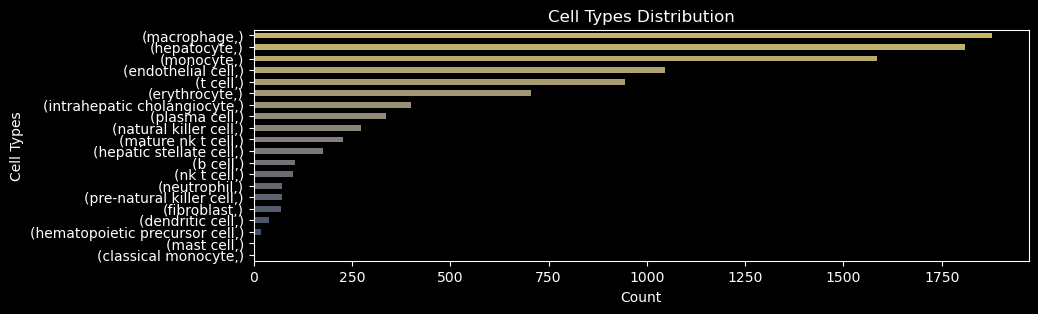

In [4]:
cell_type_counts = pd.DataFrame({'cell_types': ref_obj.obs['free_annotation']}).value_counts()
print(cell_type_counts)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
fig.patch.set_facecolor('black')
cell_type_counts = cell_type_counts.sort_values(ascending=False)
colors = plt.cm.cividis_r(np.linspace(0.2, 0.8, len(cell_type_counts)))
cell_type_counts.plot(kind='barh', ax=ax, color=colors)
ax.invert_yaxis()
ax.set_xlabel('Count', color='white')
ax.set_ylabel('Cell Types', color='white')
ax.set_title('Cell Types Distribution', color='white')
ax.set_facecolor('black')
ax.tick_params(colors='white')
for spine in ax.spines.values():
    spine.set_edgecolor('white')
plt.show()

We will further perform some QC and filter out cells. First we plot three observation features: n_genes_by_counts, total_counts, and pct_counts_mt.

n_genes_by_counts -> Count of different genes that expressed. Has non-zero value in `.X` matrix along `axis=1`.

total_counts -> Total count of the genes that expressed. Sum of non-zero value in `.X` matrix along `axis=1`

pct_counts_mt -> Percentage of mitochondrial genes that expressed among genes that expressed. To see how many genes are mitochondrial, check out    `ref_obj.var['mt'].value_counts()`.

We can print a generic statistic of these three variables and plot them for visual inspections as follows:

In [5]:
obs_variables = ['n_genes_by_counts', 'total_counts', 'pct_counts_mt']
ref_obj.obs[obs_variables].describe()

,n_genes_by_counts,total_counts,pct_counts_mt
count,9855.000000,9855.000000,9855.000000
mean,2769.281684,10111.371487,16.391269
std,1291.506802,7019.913540,8.048052
min,370.000000,2792.000000,0.347399
25%,1843.000000,5428.500000,11.042725
50%,2528.000000,7817.000000,16.034066
75%,3577.500000,12802.000000,22.066421
max,10628.000000,88390.000000,50.362250


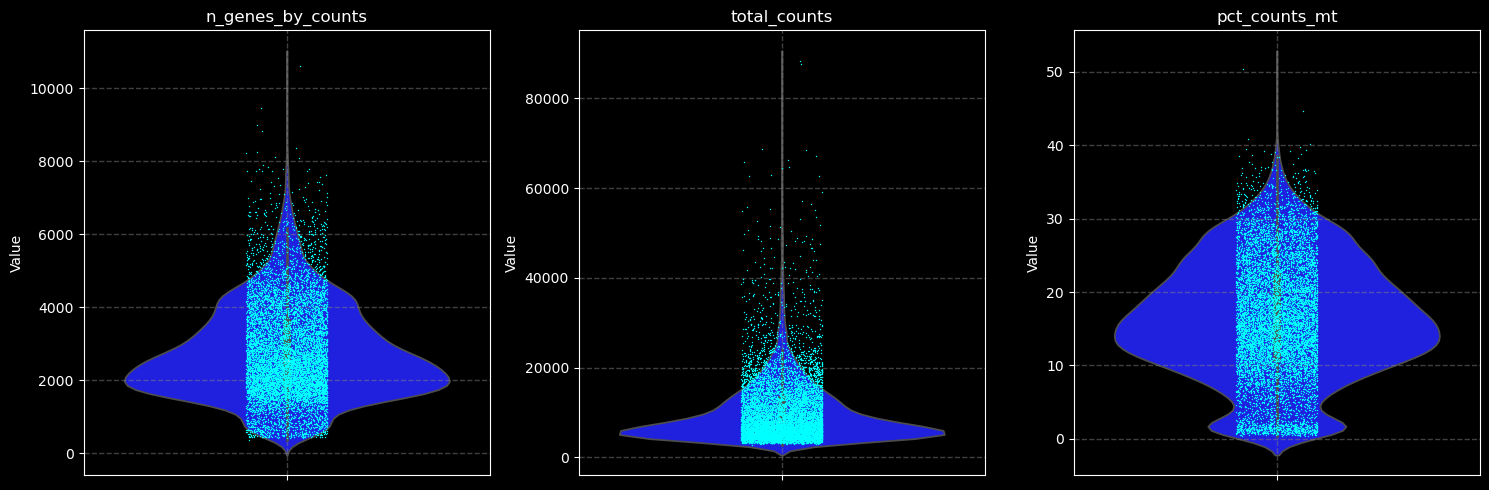

In [6]:
plot_variables = ['n_genes_by_counts', 'total_counts', 'pct_counts_mt']
fig, axes = plt.subplots(nrows=1, ncols=len(plot_variables), figsize=(15, 5))
fig.patch.set_facecolor('black')
# Prepare data for seaborn violin plot
for i, variable in enumerate(plot_variables):
    ax = axes[i]
    plot_df = pd.DataFrame(ref_obj.obs[f'{variable}'])
    sns.violinplot(y=f'{variable}', data=plot_df, color='blue', ax=ax)
    sns.stripplot(y=f'{variable}', data=plot_df, ax=ax, color='cyan', size=1, jitter=True)
    ax.set_ylabel('Value', color='white')
    ax.set_xlabel('')
    ax.set_title(f'{variable}', color='white')
    ax.set_facecolor('black')
    ax.tick_params(colors='white')
    for spine in ax.spines.values():
        spine.set_edgecolor('white')
    ax.grid(True, color='gray', linestyle='--', linewidth=1., alpha=0.5)
plt.tight_layout()
plt.show()


As you can see, the minimum `n_genes_by_counts` is `370` which is great. So, we won't filter out any cells based on this metric. However, from the `pct_counts_mt` plot we see that there are a lot of cells that express more than `10%` mitochondrial genes. 

In [7]:
ref_obj = ref_obj[ref_obj.obs['pct_counts_mt'] < 10]
ref_obj

View of AnnData object with n_obs × n_vars = 2038 × 61806
    obs: 'donor', 'tissue', 'anatomical_position', 'method', 'cdna_plate', 'library_plate', 'notes', 'cdna_well', 'old_index', 'assay', 'sample_id', 'replicate', '10X_run', '10X_barcode', 'ambient_removal', 'donor_method', 'donor_assay', 'donor_tissue', 'donor_tissue_assay', 'cell_ontology_class', 'cell_ontology_id', 'compartment', 'broad_cell_class', 'free_annotation', 'manually_annotated', 'published_2022', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ercc', 'pct_counts_ercc', '_scvi_batch', '_scvi_labels', 'scvi_leiden_donorassay_full', 'age', 'sex', 'ethnicity', 'scvi_leiden_res05_tissue', 'sample_number'
    var: 'ensembl_id', 'gene_symbol', 'genome', 'mt', 'ercc', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: '_scvi_manager_uuid', '_scvi_uuid', '_training_mode', 'age_colors', 'assay_colors', 'compartment_colors', 'donor_colors',

We can see that we have now restricted to only 2038 cells. So, far we have not done any filtering on genes. We will focus on filtering out possible low-quality genes that do not express in any cells at all.
We can do so by investigating the `n_cells_by_counts` variable which is plotted below. We can see that a lot of cells do not express any genes at all.

unexpressed_genes = 25197
n_cells_by_counts stat
--------------------
count    6.180600e+04
mean     7.429170e+04
std      1.787795e+05
min      0.000000e+00
25%      2.190000e+02
50%      2.758500e+03
75%      3.967150e+04
max      1.967927e+06
Name: n_cells_by_counts, dtype: float64


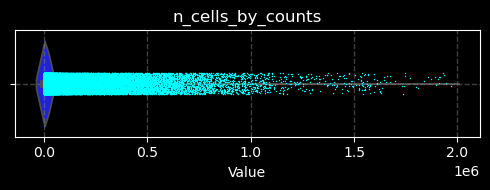

In [8]:
print(f'unexpressed_genes = {len(np.where(np.sum(ref_obj.X.todense(), axis=0) == 0)[0])}')
print(f'n_cells_by_counts stat\n--------------------\n{ref_obj.var['n_cells_by_counts'].describe()}')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 2))
fig.patch.set_facecolor('black')
# Prepare data for seaborn violin plot
plot_df = pd.DataFrame(ref_obj.var['n_cells_by_counts'])
sns.violinplot(x='n_cells_by_counts', data=plot_df, color='blue', ax=ax)
sns.stripplot(x='n_cells_by_counts', data=plot_df, ax=ax, color='cyan', size=1, jitter=True)
ax.set_xlabel('Value', color='white')
ax.set_ylabel('')
ax.set_title('n_cells_by_counts', color='white')
ax.set_facecolor('black')
ax.tick_params(colors='white')
for spine in ax.spines.values():
    spine.set_edgecolor('white')
ax.grid(True, color='gray', linestyle='--', linewidth=1., alpha=0.5)
plt.tight_layout()
plt.show()

In [9]:
#We will filter out genes that is not expressed in at least 5% of the cells.
#And we can see that we have restricted to only 50785 genes now.
ref_obj = ref_obj[:, ref_obj.var['n_cells_by_counts']>int(ref_obj.shape[0] * 0.05)]
ref_obj

View of AnnData object with n_obs × n_vars = 2038 × 50785
    obs: 'donor', 'tissue', 'anatomical_position', 'method', 'cdna_plate', 'library_plate', 'notes', 'cdna_well', 'old_index', 'assay', 'sample_id', 'replicate', '10X_run', '10X_barcode', 'ambient_removal', 'donor_method', 'donor_assay', 'donor_tissue', 'donor_tissue_assay', 'cell_ontology_class', 'cell_ontology_id', 'compartment', 'broad_cell_class', 'free_annotation', 'manually_annotated', 'published_2022', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ercc', 'pct_counts_ercc', '_scvi_batch', '_scvi_labels', 'scvi_leiden_donorassay_full', 'age', 'sex', 'ethnicity', 'scvi_leiden_res05_tissue', 'sample_number'
    var: 'ensembl_id', 'gene_symbol', 'genome', 'mt', 'ercc', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: '_scvi_manager_uuid', '_scvi_uuid', '_training_mode', 'age_colors', 'assay_colors', 'compartment_colors', 'donor_colors',

-------FINAL CELL TYPES IN REFERENCE DATASET-------
cell_types                  
hepatocyte                      830
macrophage                      423
plasma cell                     211
endothelial cell                175
erythrocyte                     130
t cell                          114
monocyte                         43
intrahepatic cholangiocyte       29
fibroblast                       17
hepatic stellate cell            12
hematopoietic precursor cell     11
natural killer cell              10
nk t cell                        10
pre-natural killer cell           9
dendritic cell                    6
b cell                            6
neutrophil                        1
mature nk t cell                  1
Name: count, dtype: int64


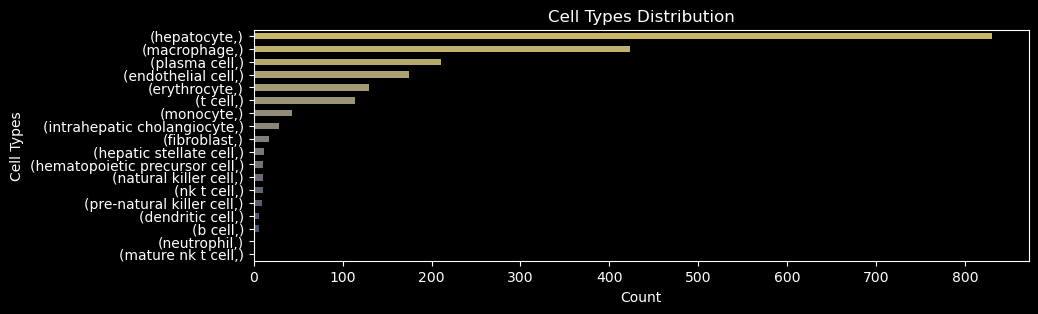

In [10]:
# Now lets see again the various cell types in the reference dataset.
print(f'-------FINAL CELL TYPES IN REFERENCE DATASET-------')
cell_type_counts = pd.DataFrame({'cell_types': ref_obj.obs['free_annotation']}).value_counts()
print(cell_type_counts)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
fig.patch.set_facecolor('black')
cell_type_counts = cell_type_counts.sort_values(ascending=False)
colors = plt.cm.cividis_r(np.linspace(0.2, 0.8, len(cell_type_counts)))
cell_type_counts.plot(kind='barh', ax=ax, color=colors)
ax.invert_yaxis()
ax.set_xlabel('Count', color='white')
ax.set_ylabel('Cell Types', color='white')
ax.set_title('Cell Types Distribution', color='white')
ax.set_facecolor('black')
ax.tick_params(colors='white')
for spine in ax.spines.values():
    spine.set_edgecolor('white')
plt.show()

**So far so good! Now we will focus on loading the liver cancer dataset and perform QC and filtering.**

## 2. Liver Cancer Dataset

In [11]:
with FeatureMatrixLoader(f"{project_path}/xenium_data/diseased/cell_feature_matrix.zarr.zip") as loader:
    cell_by_feature = loader.load_cell_by_feature(format='csr') #load cell by feature matrix in sparse format
    attributes = loader.get_attributes()
    print(attributes.keys())

dict_keys(['feature_ids', 'feature_keys', 'feature_types', 'major_version', 'minor_version', 'number_cells', 'number_features'])


In [12]:
print(f"The number of cells is {cell_by_feature.shape[0]}, which is same as reported in attributes: {attributes['number_cells']}.")
print(f"The number of features is {cell_by_feature.shape[1]}, which is same as reported in attributes: {attributes['number_features']}.")

The number of cells is 162628, which is same as reported in attributes: 162628.
The number of features is 539, which is same as reported in attributes: 539.


feature_types            
gene                         474
negative_control_codeword     41
negative_control_probe        20
unassigned_codeword            3
aggregate_gene                 1
Name: count, dtype: int64


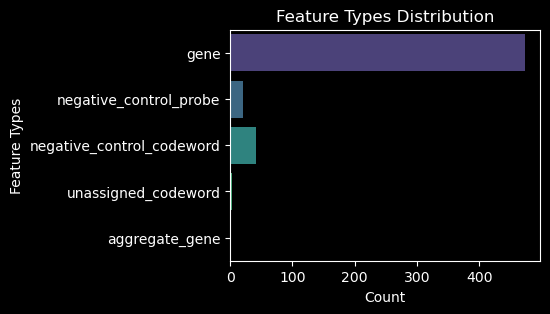

In [13]:
print(pd.DataFrame({'feature_types': attributes['feature_types']}).value_counts())
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 3))
fig.patch.set_facecolor('black')
sns.countplot(attributes['feature_types'], ax=ax, palette='viridis')
ax.set_xlabel('Count', color='white')
ax.set_ylabel('Feature Types', color='white')
ax.set_title('Feature Types Distribution', color='white')
ax.set_facecolor('black')
ax.tick_params(colors='white')
for spine in ax.spines.values():
    spine.set_edgecolor('white')
plt.show()

In [14]:
print(f'As you may see that there are actually only {int(sum(np.array(attributes["feature_types"], dtype=str) == "gene"))} genes.')
print(f'Also the last feature which is `aggregated_gene` in fact is total_transcripts for the corresponding cell.')

As you may see that there are actually only 474 genes.
Also the last feature which is `aggregated_gene` in fact is total_transcripts for the corresponding cell.


We will now create an anndata object from cell_by_feature_matrix and add necessary information on cells and features. Note that for cell by features we will avoid last column which is total number of transcripts which we will add as metadata.

In [15]:
gene_indices = np.where(np.array(attributes['feature_types'], dtype=str) == 'gene')[0]
aggregate_gene_indices = np.where(np.array(attributes['feature_types'], dtype=str) == 'aggregate_gene')[0]
xenium_obj = ad.AnnData(cell_by_feature[:, gene_indices], 
                        obs = {'total_transcripts': cell_by_feature[:, aggregate_gene_indices].toarray()[:, 0].tolist()},
                        var = {'ensembl_id': np.array(attributes['feature_ids'])[gene_indices], 
                               'gene_symbol': np.array(attributes['feature_keys'])[gene_indices]})
#Lets log1p normalize the data as well. First we save the raw/original counts in a layer called raw_counts.
xenium_obj.layers["raw_counts"] = xenium_obj.X.copy()
sc.pp.log1p(xenium_obj)
xenium_obj

AnnData object with n_obs × n_vars = 162628 × 474
    obs: 'total_transcripts'
    var: 'ensembl_id', 'gene_symbol'
    uns: 'log1p'
    layers: 'raw_counts'

In [16]:
# **GREAT**. Lets now see how many genes are common between the reference dataset and the xenium dataset.
# Since the ensembl ids do not tend to change over time, while the gene_symbols might change, we will use ensembl ids to find the common genes.
#First we will do some sanity checks on the strings of ensembl ids saved for these datasets
print('-----REFERENNCE DATASET-------')
print(((ref_obj.var['ensembl_id']).apply(lambda x: 'mixed' if any(c.isupper() for c in x) and any(c.islower() for c in x) else 'uppercase' if any(c.isupper() for c in x) else 'lowercase' if any(c.islower() for c in x) else 'none')).value_counts())
print('-----XENIUM DATASET-------')
print(((xenium_obj.var['ensembl_id']).apply(lambda x: 'mixed' if any(c.isupper() for c in x) and any(c.islower() for c in x) else 'uppercase' if any(c.isupper() for c in x) else 'lowercase' if any(c.islower() for c in x) else 'none')).value_counts())
print('Good! Both the datasets have ensembl ids in uppercase format. So we should not have problem comparing them.\nWe could have also lowered these strings to ensure proper comparison, but since they are already in uppercase, we can skip that step.')
#Now lets find the common genes between the two datasets. Ther are various ways to do it.
# But since we might need the indices of the common genes for future purposes, we will use np.intersect1d with return_indices=True.
common_genes_and_indices = np.intersect1d(ref_obj.var['ensembl_id'], xenium_obj.var['ensembl_id'], return_indices=True)
print(f'The number of common genes between the reference dataset and the xenium dataset is {len(common_genes_and_indices[0])}.')
print('So almost all of the genes in the xenium dataset are present in the reference dataset.')

-----REFERENNCE DATASET-------
ensembl_id
uppercase    50785
Name: count, dtype: int64
-----XENIUM DATASET-------
ensembl_id
uppercase    474
Name: count, dtype: int64
Good! Both the datasets have ensembl ids in uppercase format. So we should not have problem comparing them.
We could have also lowered these strings to ensure proper comparison, but since they are already in uppercase, we can skip that step.
The number of common genes between the reference dataset and the xenium dataset is 471.
So almost all of the genes in the xenium dataset are present in the reference dataset.


**Lets now evaluate the gene expression correlation between the two datasets.**
We will define the same get_gex_means function as in the analysis guide.

In [17]:
def get_gex_means(xenium_obj, ref_obj):
    # Calculate mean counts for Xenium
    xen_means = pd.DataFrame({
        "mean_counts": xenium_obj.layers['raw_counts'].mean(axis=0).tolist()[0],
        "gene": xenium_obj.var['ensembl_id']
    }).sort_values(by="mean_counts", ascending=False)
    xen_means["Rank"] = range(1, len(xen_means) + 1)

    # Calculate mean counts for reference
    ref_means = pd.DataFrame({
        "mean_counts": ref_obj.layers['raw_counts'].mean(axis=0).tolist()[0],
        "gene": ref_obj.var['ensembl_id']
    }).sort_values(by="mean_counts", ascending=False)
    ref_means["Rank"] = range(1, len(ref_means) + 1)

    # Merge on gene
    merged_means = pd.merge(xen_means, ref_means, on="gene", how="left", suffixes=('_xenium', '_ref'))

    return merged_means


In [18]:
# Load gene panel JSON
with open(f"{project_path}/xenium_data/diseased/gene_panel.json", "r") as f:
    gene_panel = json.load(f)

# Extract targets
targets = gene_panel["payload"]["targets"]

# Create panel_source DataFrame
panel_source = pd.DataFrame({
    "gene_panel": [t["source"]["identity"]["name"] for t in targets],
    "gene": [t["type"]["data"].get('id', np.nan) for t in targets]
})

# Get merged means
merged_means = get_gex_means(xenium_obj, ref_obj)

# Merge with panel_source
merged_means = pd.merge(panel_source, merged_means, on="gene", how="left")

In [19]:
merged_means

,gene_panel,gene,mean_counts_xenium,Rank_xenium,mean_counts_ref,Rank_ref
0,Xenium Human Multi-Tissue + Add-on Gene Expres...,ENSG00000072110,0.888666,38.0,1.487733,1781.0
1,Xenium Human Multi-Tissue + Add-on Gene Expres...,ENSG00000196139,0.550145,60.0,0.675662,3951.0
2,Xenium Human Multi-Tissue + Add-on Gene Expres...,ENSG00000132965,0.053632,250.0,0.274779,7276.0
3,Xenium Human Multi-Tissue + Add-on Gene Expres...,ENSG00000243480,0.054788,247.0,0.000000,47685.0
4,Xenium Human Multi-Tissue + Add-on Gene Expres...,ENSG00000138772,0.058127,240.0,0.107949,11021.0
...,...,...,...,...,...,...
492,Xenium Human Multi-Tissue and Cancer Gene Expr...,NaN,NaN,NaN,NaN,NaN
493,Xenium Human Multi-Tissue and Cancer Gene Expr...,NaN,NaN,NaN,NaN,NaN
494,Xenium Human Multi-Tissue and Cancer Gene Expr...,NaN,NaN,NaN,NaN,NaN
495,Xenium Human Multi-Tissue and Cancer Gene Expr...,NaN,NaN,NaN,NaN,NaN


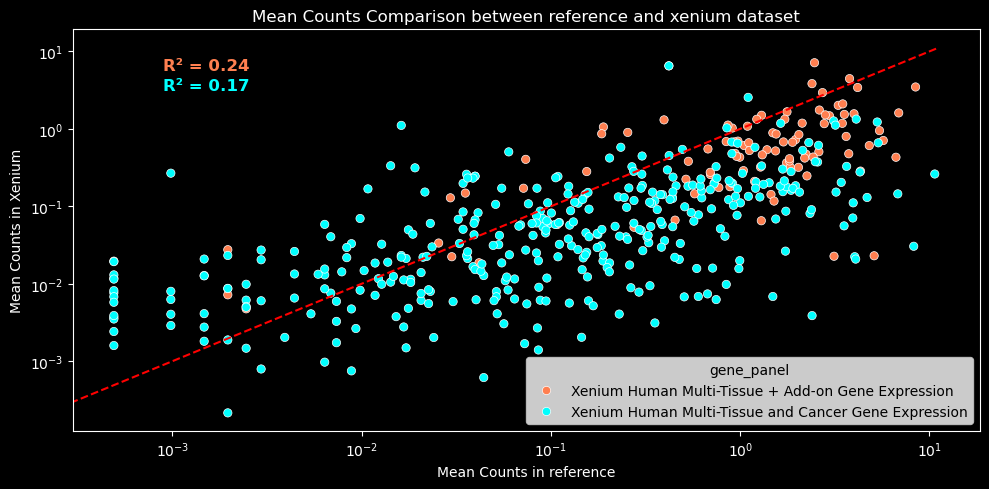

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
fig.patch.set_facecolor('black')
# Define palette and plot scatter
palette = {
    f'{merged_means["gene_panel"].unique()[1]}': 'cyan',
    f'{merged_means["gene_panel"].unique()[0]}': 'coral'}
sns.scatterplot(data=merged_means, x='mean_counts_ref', y='mean_counts_xenium', hue='gene_panel', ax=ax, palette=palette)
#Note the mean counts came from raw counts, not log1p transformed data. 
# And note there are 3 genes from xenium dataset that are not in reference dataset for which when merging two dataframes must have given NaNs at rows for mean_counts_ref.
# There are additional NaNs from some of the genes not found in gene_panel json object.
# So lets avoid them.
merged_means_filtered = merged_means.dropna()

r2_results = {}
for group, panel in merged_means_filtered.groupby('gene_panel'):
    r2_results[group] = round(linregress(np.log1p(panel['mean_counts_ref']), np.log1p(panel['mean_counts_xenium'])).rvalue**2, 2)

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
xrange = np.linspace(xmin, xmax, 100)
ax.plot(xrange, xrange, color='red', linestyle='--', linewidth=1.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Mean Counts in reference', color='white')
ax.set_ylabel('Mean Counts in Xenium', color='white')
ax.set_title('Mean Counts Comparison between reference and xenium dataset', color='white')
ax.set_facecolor('black')

for i, (panel, r2) in enumerate(r2_results.items()):
    ax.text(
        0.1, 
        0.9-i*0.05,
        f'R² = {r2:.2f}',
        color=palette[panel],
        fontsize=12,
        weight='bold',
        transform = ax.transAxes
    )

ax.tick_params(colors='white')
for spine in ax.spines.values():
    spine.set_edgecolor('white')
plt.tight_layout()
plt.show()

In [21]:
ref_obj_subset = ad.AnnData(X = ref_obj.layers['raw_counts'].copy(),
                            obs = ref_obj.obs.iloc[:, [19, 21, 22, 23, 29, -2]].copy(),
                            var = ref_obj.var[['ensembl_id', 'gene_symbol', 'mt']].copy())
ref_obj_subset

AnnData object with n_obs × n_vars = 2038 × 50785
    obs: 'cell_ontology_class', 'compartment', 'broad_cell_class', 'free_annotation', 'pct_counts_mt', 'scvi_leiden_res05_tissue'
    var: 'ensembl_id', 'gene_symbol', 'mt'

In [22]:
sc.pp.normalize_total(ref_obj_subset, target_sum=1e4)
sc.pp.log1p(ref_obj_subset)
sc.pp.highly_variable_genes(ref_obj_subset, n_top_genes=int(0.05*ref_obj_subset.shape[1]), flavor='seurat_v3')
sc.pp.scale(ref_obj_subset)
sc.pp.pca(ref_obj_subset, svd_solver='arpack')
sc.pp.neighbors(ref_obj_subset, n_pcs=15)
sc.tl.umap(ref_obj_subset)
sc.tl.leiden(ref_obj_subset, resolution=0.5)

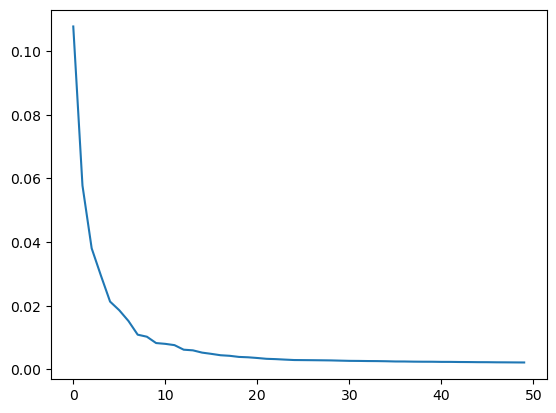

In [35]:
plt.plot(ref_obj_subset.uns['pca']['variance_ratio'])
plt.show()

In [38]:
ref_obj_subset

AnnData object with n_obs × n_vars = 2038 × 50785
    obs: 'cell_ontology_class', 'compartment', 'broad_cell_class', 'free_annotation', 'pct_counts_mt', 'scvi_leiden_res05_tissue', 'leiden'
    var: 'ensembl_id', 'gene_symbol', 'mt', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

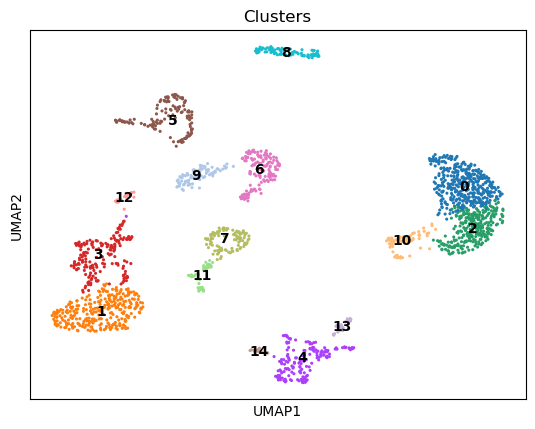

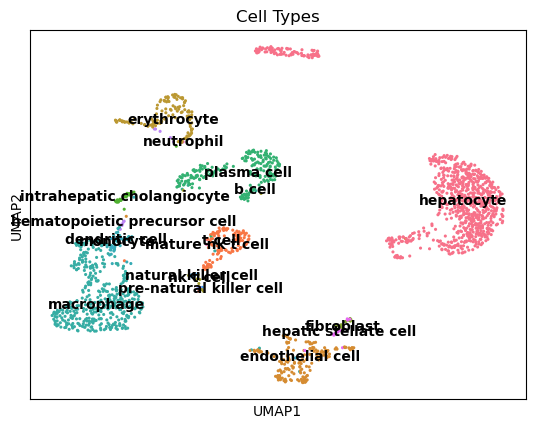

In [39]:
# Define color palette and corresponding cell type names
cell_type_names = ref_obj_subset.obs['free_annotation'].unique()
custom_hex = sns.color_palette("husl", len(cell_type_names)).as_hex()
palette = dict(zip(cell_type_names, custom_hex))

# Plot 1: Clustering (equivalent to group.by = "RNA_snn_res.0.5")
sc.pl.umap(
    ref_obj_subset,
    color="leiden",
    size=20,
    title="Clusters",
    legend_loc='on data',
    show=False
)

# Plot 2: Cell types with custom colors
# You must make sure the categories are ordered like in cell_type_names
sc.pl.umap(
    ref_obj_subset,
    color='free_annotation',
    palette=palette,
    size=20,
    title="Cell Types",
    legend_loc='on data',
    show=False
)

plt.show()


In [42]:
sc.pp.normalize_total(xenium_obj, target_sum=1e4)
sc.pp.log1p(xenium_obj)
sc.pp.highly_variable_genes(xenium_obj, flavor='seurat_v3', n_top_genes=int(0.05*ref_obj_subset.shape[1]))
sc.pp.scale(xenium_obj)
sc.tl.pca(xenium_obj, svd_solver='arpack')
sc.pp.neighbors(xenium_obj, n_pcs=15)
sc.tl.umap(xenium_obj)
sc.tl.leiden(xenium_obj, resolution=0.5)

<Axes: title={'center': 'Clusters'}, xlabel='UMAP1', ylabel='UMAP2'>

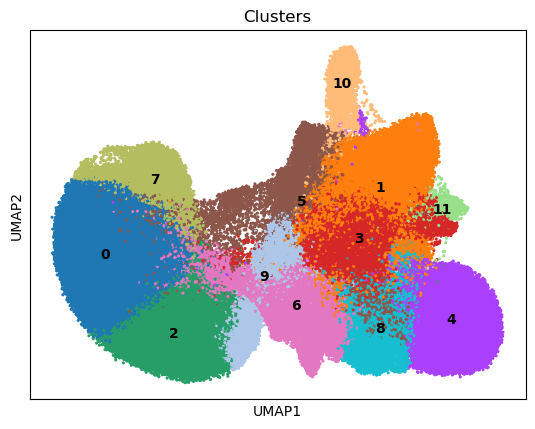

In [95]:
sc.pl.umap(
    xenium_obj,
    color="leiden",
    size=20,
    title="Clusters",
    legend_loc='on data',
    show=False
)

In [79]:
common_genes, idx_for_xenium, idx_for_ref = np.intersect1d(xenium_obj.var['ensembl_id'],ref_obj_subset.var['ensembl_id'], return_indices=True)
xenium_obj2 = (xenium_obj[:, idx_for_xenium]).copy()
ref_obj2 = (ref_obj_subset[:, idx_for_ref]).copy()
xenium_obj2.var.index = xenium_obj2.var['ensembl_id']
ref_obj2.var.index = ref_obj2.var['ensembl_id']

In [85]:
print(f'idx for reference: {ref_obj2.var.index[:3]}')
print(f'idx for xenium: {xenium_obj2.var.index[:3]}')

idx for reference: Index(['ENSG00000001626', 'ENSG00000003436', 'ENSG00000004939'], dtype='object', name='ensembl_id')
idx for xenium: Index(['ENSG00000001626', 'ENSG00000003436', 'ENSG00000004939'], dtype='object', name='ensembl_id')


In [86]:
sc.tl.ingest(
    xenium_obj2,
    ref_obj2,
    obs='free_annotation',
    embedding_method='umap'
)

<Axes: title={'center': 'Clusters'}, xlabel='UMAP1', ylabel='UMAP2'>

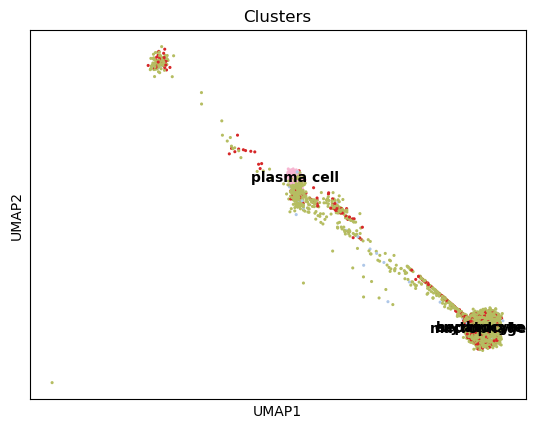

In [96]:
sc.pl.umap(
    xenium_obj2,
    color="free_annotation",
    size=20,
    title="Clusters",
    legend_loc='on data',
    show=False
)